# Colorize Grayscale Images

I've been followed the beginner tensorflow tutorial for transfer learning with pretrained CNNs (https://www.tensorflow.org/beta/tutorials/images/transfer_learning)

I will use Tensorflow 2.0.0-beta1 to train my model.
I will create the model from pre-trained convnets MobileNet V2 and I will use transfer learning to customize it to recognize cats and dogs.

I will convert and export the trained model to TFLite and I will run it in Android app to identify real time cats and dogs.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from bs4 import BeautifulSoup
import requests
import PIL.Image
import urllib
print(tf.__version__)

2.0.0-beta1


# Download dataset

In [3]:
imagenet_categories = [("ship", "n04194289"),
                       ("people", "n07942152"),
                       ("kid", "n09918248"),
                       ("woman", "n10787470"),
                       ("school", "n04146050"),
                       ("stage", "n04296562"),
                       ("girlfriend", "n10130686")]

In [4]:
train_path = 'train'
validation_path = 'validation'

# create the train and validation folders
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)

# # create a folder for each category
# for name, synset in imagenet_categories:
#     os.makedirs(train_path + '/' + name, exist_ok=True)
#     os.makedirs(validation_path + '/' + name, exist_ok=True)

In [5]:
soup_arr = []

for name, synset in imagenet_categories:
    page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=" + synset)
    # BeautifulSoup is an HTML parsing library
    # puts the content of the website into the soup variable, each url on a different line
    soup_arr.append(BeautifulSoup(page.content, 'html.parser'))
print(len(soup_arr))

7


In [6]:
split_urls = []

for i in range(len(soup_arr)):
    #convert soup to string so it can be split
    str_soup=str(soup_arr[i])
    type(str_soup)
    #split so each url is a different possition on a list
    split_urls.append(str_soup.split('\r\n'))
    #print the length of the list so you know how many urls you have
    print(imagenet_categories[i][0] + " = " + str(len(split_urls[i])))

ship = 1262
people = 1432
kid = 1328
woman = 1406
school = 1213
stage = 1232
girlfriend = 6


1262
progress = 0
1432
progress = 0
1328
progress = 0
1406
progress = 0
1213
progress = 0
1232
progress = 0
6
progress = 0
exception
<class 'Exception'>


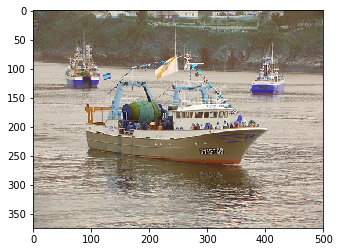

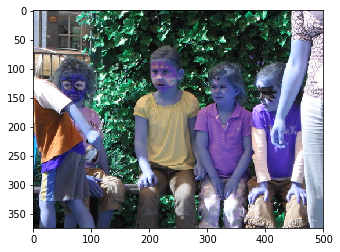

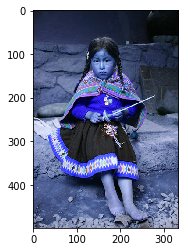

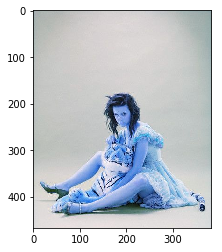

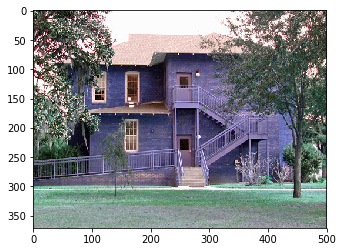

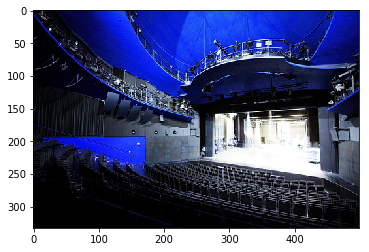

In [22]:
# #number of rows and columns to convert the images to
# img_rows, img_cols = 32, 32 
# #format to store the images (rows, columns,channels) called channels last
# input_shape = (img_rows, img_cols, 3)

# def url_to_image(url):
#     # download the image, convert it to a NumPy array, and then read
#     # it into OpenCV format
#     resp = urllib.request.urlopen(url)
#     image = np.asarray(bytearray(resp.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#     return image

# #the number of training images to use
# n_of_training_images=100

# # Train data
# # iterate over each category
# for i in range(len(imagenet_categories)):
#     category_urls = split_urls[i]
#     print(len(category_urls))
    
#     for progress in range(n_of_training_images):
#         # Print out progress whenever progress is a multiple of 20 so we can follow the
#         # (relatively slow) progress
#         if(progress%20==0):
#             print('progress = ' + str(progress))
        
#         if progress < len(category_urls) and not category_urls[progress] == None:
#             try:
#                 downloaded_image = url_to_image(category_urls[progress])
#                 #check if the image has width, length and channels
#                 if (len(downloaded_image.shape))==3: 
#                     #create a name of each image
#                     save_path = train_path + '/img_' + imagenet_categories[i][0] + '_' + str(progress)+'.jpg'
#                     cv2.imwrite(save_path, downloaded_image)
#             except Exception as e:
#                 print("exception") 
#                 print(Exception)
        
# # #Validation data:
# for i in range(len(imagenet_categories)):
#     category_urls = split_urls[i]
#     print(len(category_urls))
    
#     for progress in range(50):
#         # Print out progress whenever progress is a multiple of 20 so we can follow the
#         # (relatively slow) progress
#         if(progress%20==0):
#             print('progress = ' + str(progress))
        
#         if progress < len(category_urls) and not category_urls[progress] == None:
#             try:
#                 # we take different images
#                 downloaded_image = url_to_image(category_urls[n_of_training_images+progress])
#                 #check if the image has width, length and channels
#                 if (len(downloaded_image.shape))==3: 
#                     #create a name of each image
#                     save_path = validation_path + '/img_' + imagenet_categories[i][0] + '_' + str(progress)+'.jpg'
#                     cv2.imwrite(save_path, downloaded_image)
#             except Exception as e:
#                 print("exception") 
        


# Load Dataset

In [41]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def is_gray_scale(image):
    w,h = image.size
    for i in range(w):
        for j in range(h):
            r,g,b = image.getpixel((i,j))
            if r != g != b: return False
    return True

<MapDataset shapes: (192, 192, 3), types: tf.float32>
train size = 404, random train images:


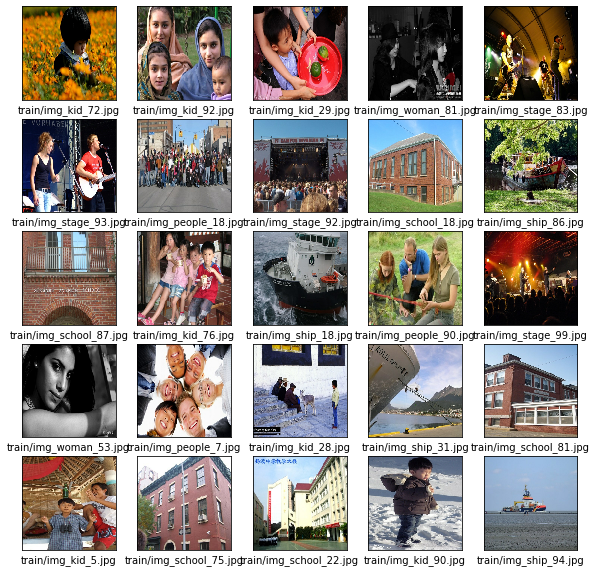

In [11]:
import IPython.display as display
import glob
import random

all_train_image_paths = list(glob.glob('train/*'))
all_train_image_paths = [str(path) for path in all_train_image_paths]
random.shuffle(all_train_image_paths)

train_x_ds = tf.data.Dataset.from_tensor_slices(all_train_image_paths)
train_x_image_ds = train_x_ds.map(load_and_preprocess_image)

print(train_x_image_ds)

image_count = len(all_train_image_paths)
print('train size = ' + str(image_count) + ', random train images:')

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(load_and_preprocess_image(all_train_image_paths[i]))
    plt.xlabel(all_train_image_paths[i])
plt.show()

<MapDataset shapes: (192, 192, 3), types: tf.float32>
validation size = 202, random validation images:


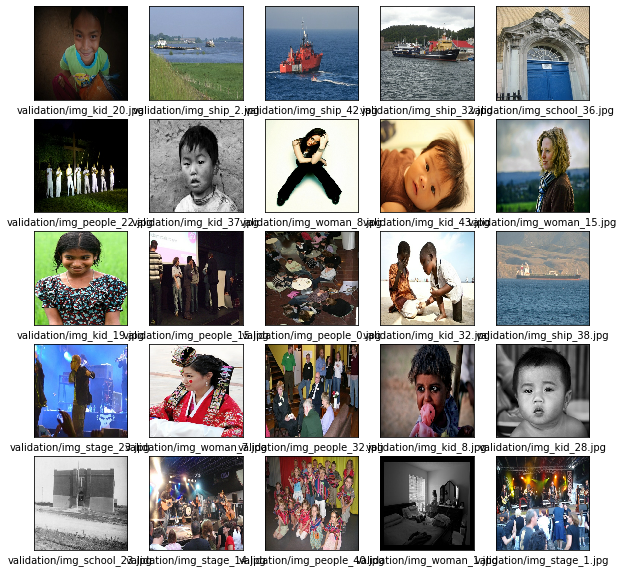

In [12]:
import IPython.display as display
import glob
import random

all_validation_image_paths = list(glob.glob('validation/*'))
all_validation_image_paths = [str(path) for path in all_validation_image_paths]
random.shuffle(all_validation_image_paths)

validation_y_ds = tf.data.Dataset.from_tensor_slices(all_validation_image_paths)
validation_y_image_ds = validation_y_ds.map(load_and_preprocess_image)
print(validation_y_image_ds)

image_count = len(all_validation_image_paths)
print('validation size = ' + str(image_count) + ', random validation images:')

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(load_and_preprocess_image(all_validation_image_paths[i]))
    plt.xlabel(all_validation_image_paths[i])
plt.show()

In [79]:
def show_images(original, model_prediction, grayscale):
    
    plt.figure(figsize=(20,20))

    plt.subplot(3,3,1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original)
    plt.xlabel("original")

    plt.subplot(3,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(grayscale, cmap =plt.cm.gray)
    plt.xlabel("grayscale")

    plt.subplot(3,3,3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_prediction)
    plt.xlabel("rgb prediction")

    plt.show()

In [14]:
#!pip install -U scikit-image
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_X = []
train_Y = []

for image_path in all_train_image_paths:
    image_arr = img_to_array(load_and_preprocess_image(image_path))
    image_arr = np.array(image_arr, dtype=float)
    
    X = rgb2lab(1.0/255*image_arr)[:,:,0]
    Y = rgb2lab(1.0/255*image_arr)[:,:,1:]
    Y /= 128
    
    X = X.reshape(192, 192, 1)
    Y = Y.reshape(192, 192, 2)
    
    train_X.append(X)
    train_Y.append(Y)

train_inputs = np.array(train_X)
train_targets = np.array(train_Y)

print("train_inputs shape = " + str(train_inputs.shape))
print("train_targets shape = " + str(train_targets.shape))

train_inputs shape = (404, 192, 192, 1)
train_targets shape = (404, 192, 192, 2)


In [32]:
validation_X = []
validation_Y = []

for image_path in all_validation_image_paths:
    image_arr = img_to_array(load_and_preprocess_image(image_path))
    image_arr = np.array(image_arr, dtype=float)
    
    X = rgb2lab(1.0/255*image_arr)[:,:,0]
    Y = rgb2lab(1.0/255*image_arr)[:,:,1:]
    Y /= 128
    
    X = X.reshape(192, 192, 1)
    Y = Y.reshape(192, 192, 2)
    
    validation_X.append(X)
    validation_Y.append(Y)

validation_inputs = np.array(validation_X)
validation_targets = np.array(validation_Y)

print("validation_inputs shape = " + str(validation_inputs.shape))
print("validation_targets validation shape = " + str(validation_targets.shape))

validation_inputs shape = (202, 192, 192, 1)
validation_targets validation shape = (202, 192, 192, 2)


In [33]:
# Building the neural network
model = tf.keras.Sequential([
    layers.InputLayer((None, None, 1)),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(2, (3, 3), activation='tanh', padding='same'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 8)     80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 32)    0

In [34]:
# Finish model
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

In [85]:
print(train_targets.min())
print(train_targets.max())

-0.0030197283534329515
0.003043492069912802


In [71]:
history = model.fit(train_inputs, 
          train_targets,
          batch_size=1,
          epochs=5
          ,
          validation_data=(validation_inputs, validation_targets)
         )


Train on 404 samples, validate on 202 samples
Epoch 1/5
404/404 [==============================] - 29s 73ms/sample - loss: 3.5120e-07 - accuracy: 0.5216 - val_loss: 1.0074e-06 - val_accuracy: 0.3940
Epoch 2/5
404/404 [==============================] - 28s 70ms/sample - loss: 3.8005e-07 - accuracy: 0.4933 - val_loss: 4.6511e-07 - val_accuracy: 0.6060
Epoch 3/5
404/404 [==============================] - 28s 69ms/sample - loss: 3.6440e-07 - accuracy: 0.4969 - val_loss: 1.7064e-07 - val_accuracy: 0.6060
Epoch 4/5
404/404 [==============================] - 28s 70ms/sample - loss: 3.7084e-07 - accuracy: 0.5020 - val_loss: 1.2747e-07 - val_accuracy: 0.3940
Epoch 5/5
404/404 [==============================] - 29s 72ms/sample - loss: 3.6160e-07 - accuracy: 0.5158 - val_loss: 6.0378e-07 - val_accuracy: 0.6060


In [69]:
loss, accuracy = model.evaluate(train_inputs, train_targets, batch_size=1)
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))


404/404 [==============================] - 3s 8ms/sample - loss: 9.9980e-08 - accuracy: 0.6042
initial loss: 0.00
initial accuracy: 0.60


# Learning curves

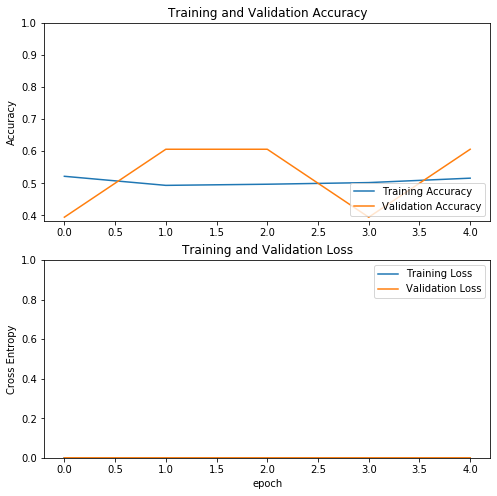

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save the model

In [73]:
model.save('Colorize.h5')

# Recreate the model

In [ ]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('catVsDogsModel.h5')
new_model.summary()

In [ ]:
new_loss, new_accuracy = new_model.evaluate(validation_batches, steps = 20)
print("Restored model, accuracy: {:5.2f}%".format(100*new_accuracy))
print("Restored model, loss: {:5.2f}%".format(new_loss))

# Predict

<PIL.Image.Image image mode=RGB size=400x400 at 0x17DF06E48>
(400, 400, 3)


/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 163 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


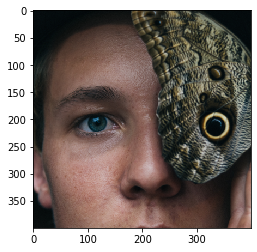

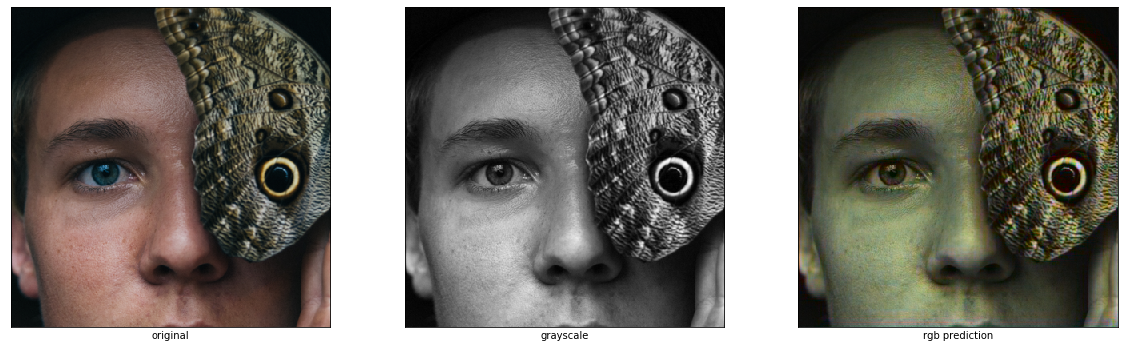

In [84]:
def load_img_to_np_array(image_path, show_image = False):
    raw_image = load_img(image_path)
    image_arr = img_to_array(raw_image)
    imaimage_arrge = np.array(image_arr, dtype=float)

    if (show_image):
        plt.figure()
        plt.imshow(raw_image)
    return raw_image, image_arr

def predict(original_image, inputX):
    output = model.predict(inputX)
    output *= 128
    # Output colorizations
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = inputX[0][:,:,0]
    cur[:,:,1:] = output[0]
    
    predicted_image = lab2rgb(cur)
    show_images(original_image, predicted_image, rgb2gray(predicted_image))
    
def preprocess_to_lab(image_arr):
    X = rgb2lab(1.0/255*image_arr)[:,:,0]
    Y = rgb2lab(1.0/255*image_arr)[:,:,1:]
    Y /= 128
    X = X.reshape(1, 400, 400, 1)
    Y = Y.reshape(1, 400, 400, 2)
    
    return X, Y

man_image, man_arr = load_img_to_np_array('man.jpg', show_image=True)
print(man_image)
print(man_arr.shape)
man_x, man_y = preprocess_to_lab(man_arr)
predict(man_image, man_x)

# Convert the Model to TFLite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Export The Model

In [ ]:
open("catVsDogs_model.tflite", "wb").write(tflite_model)